In [1]:
# !pip install datasets
# !pip install transformers
# !pip install -U accelerate
# !pip install optuna
# !pip install shap
# !pip install lime
# !pip install transformers-interpret
# !pip install omnixai
# !pip install ipython>=8.10.0
# !pip install captum
# !pip install git+https://github.com/yidinghao/interpreting-nlp
# !pip install yattag

# !pip install pyarabic

#Data

In [2]:
import pickle

with open('train_final.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('test_final.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('val_final.pkl', 'rb') as f:
    X_dev = pickle.load(f)

In [3]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}

classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [4]:
X_train.head()

,tweet,label,tweet_with_out_emojis,cleaned_data,Root Stemming,Light Stemming
5081,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,مهند ياحبيبي تدور لبش متاكد ابو جاسم مايدري,هند حبب تدر لبش تكد ابو جسم ايدر,مهند ياحبيبي تدور لبش متاكد ابو جاسم مايدري
8264,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفرين اعتقال عشرات الشباب قريه باسوطه ريف ...,حلب عفر عقل عشر شبب قره بسط ريف عفر قوت هرب عش...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...
9777,انا نفسي مره اجرب اكون ليك حد اقرب : ),3,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,مره جرب اكن ليك قرب,مره اجرب اكون ليك اقرب
740,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,صرح حسس خزي كتف شرف اوليمبياد عوز صحه ريض,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...
6537,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,عجل يطل ابو بسل يفز دهب اوليمبياد جودو بطل علم...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...


In [5]:
X_train = X_train[['tweet', 'label']]
y_train = X_train['label']
X_test = X_test[['tweet','label']]
y_test = X_test['label']
X_dev = X_dev[['tweet', 'label']]
y_dev = X_dev['label']

In [6]:
X_train.shape, X_test.shape, X_dev.shape

((7045, 2), (1510, 2), (1510, 2))

In [7]:
X_train

,tweet,label
5081,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1
8264,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3
9777,انا نفسي مره اجرب اكون ليك حد اقرب : ),3
740,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3
6537,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0
...,...,...
5734,احمد الاحمر اوحش لاعب في الاوليمبياد ... اخره ...,3
5191,انتي كان قصدك عليا !,6
5390,يا جدعان لو سمحتوا مش كل واحد عنده ميتين ام عق...,1
860,هتودينا في دهيا يا بلال ارحمنا ده مش وقت قلش,1


In [8]:
X_train = X_train.rename_axis('id')
X_test = X_test.rename_axis('id')
X_dev = X_dev.rename_axis('id')

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_dev = X_dev.reset_index(drop=True)

In [9]:
from datasets import Dataset

X_train = Dataset.from_pandas(X_train)
X_test = Dataset.from_pandas(X_test)
X_dev = Dataset.from_pandas(X_dev)
X_train, X_test, X_dev

(Dataset({
     features: ['tweet', 'label'],
     num_rows: 7045
 }),
 Dataset({
     features: ['tweet', 'label'],
     num_rows: 1510
 }),
 Dataset({
     features: ['tweet', 'label'],
     num_rows: 1510
 }))

#Transformer

##Setup

In [10]:
model_checkpoint = 'UBC-NLP/MARBERTv2'

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [12]:
from transformers import AutoModelForSequenceClassification
# from interpret_nlp.modules.lrp_bert_modules import LRPBertForSequenceClassification

model_init = lambda: AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=8)
# model_init = lambda: LRPBertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=8)

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["tweet"], padding="max_length", truncation=True, max_length=37)

X_train = X_train.map(tokenize_function, batched=True, num_proc = 8)
X_dev = X_test.map(tokenize_function, batched=True, num_proc = 8)
X_test = X_test.map(tokenize_function, batched=True, num_proc = 8)

Map (num_proc=8):   0%|          | 0/7045 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1510 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1510 [00:00<?, ? examples/s]

In [14]:
X_train

Dataset({
    features: ['tweet', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7045
})

##Model

###Train

In [15]:
import numpy as np
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score
                             )

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_f1 = f1_score(p.label_ids,preds,average='macro', zero_division=1)
    macro_precision = precision_score(p.label_ids,preds,average='macro', zero_division=1)
    macro_recall = recall_score(p.label_ids,preds,average='macro', zero_division=1)
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }

In [16]:
# best run parameters
# dict_items([('learning_rate', 5.9572096694887074e-05), ('num_train_epochs', 4), ('seed', 34), ('per_device_train_batch_size', 16)])

In [17]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy

batch_size = 16
logging_steps = 100
num_epochs = 4

training_args = TrainingArguments(output_dir="./train")
training_args.do_train = True
training_args.evaluate_during_training = True
training_args.per_device_train_batch_size = batch_size
training_args.per_device_eval_batch_size = batch_size
training_args.evaluation_strategy = IntervalStrategy.STEPS
training_args.num_train_epochs = num_epochs
training_args.logging_steps = logging_steps
training_args.eval_steps = logging_steps
training_args.save_steps = 500
training_args.save_total_limit = 5
training_args.seed = 34
training_args.learning_rate = 5.9572096694887074e-05
training_args.load_best_model_at_end=True
training_args.metric_for_best_model = 'macro_f1'

In [18]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=X_train,
    eval_dataset=X_dev,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")
# best_run

[I 2023-08-20 05:28:27,738] A new study created in memory with name: no-name-da9d9502-e8de-44cf-a44c-61af0386fb25
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.316300,0.859123,0.712813,0.749277,0.721779,0.726490
200,0.862100,0.723221,0.765577,0.772809,0.766733,0.765563
300,0.767400,0.663667,0.774670,0.777210,0.775802,0.772185
400,0.692300,0.614282,0.802324,0.812749,0.798071,0.799338


[I 2023-08-20 05:29:50,210] Trial 0 finished with value: 3.212480968842792 and parameters: {'learning_rate': 8.200554756416108e-05, 'num_train_epochs': 1, 'seed': 9, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 3.212480968842792.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.811600,1.484585,0.461584,0.690599,0.537989,0.556291
200,1.239100,1.023621,0.653686,0.718403,0.680449,0.686755
300,0.987800,0.834522,0.752911,0.778828,0.753772,0.757616
400,0.870500,0.755812,0.764663,0.792967,0.764035,0.767550
500,0.708900,0.728696,0.769759,0.778334,0.768117,0.768212
600,0.665200,0.680562,0.789979,0.794952,0.789060,0.787417
700,0.617900,0.667301,0.788441,0.802356,0.785342,0.786755
800,0.636200,0.662760,0.793148,0.805360,0.788863,0.790728


[I 2023-08-20 05:32:38,132] Trial 1 finished with value: 3.1780990857134808 and parameters: {'learning_rate': 1.3938743768187241e-05, 'num_train_epochs': 4, 'seed': 19, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 3.212480968842792.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.972300,1.817034,0.369557,0.559438,0.440967,0.469536
200,1.743800,1.587729,0.450493,0.727213,0.536416,0.557616
300,1.502900,1.323296,0.561836,0.721806,0.615605,0.633113
400,1.328200,1.119197,0.610781,0.718661,0.653577,0.665563
500,1.125500,0.980799,0.688078,0.757910,0.703418,0.713245
600,1.009500,0.905773,0.720846,0.769853,0.728545,0.735762
700,0.977400,0.849459,0.746749,0.778664,0.747322,0.753642
800,0.931100,0.791454,0.765940,0.786399,0.764769,0.769536


[I 2023-08-20 05:34:48,754] Trial 2 finished with value: 3.086643588074592 and parameters: {'learning_rate': 7.243812987294525e-06, 'num_train_epochs': 4, 'seed': 29, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 3.212480968842792.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.593700,1.059493,0.666977,0.727746,0.693691,0.698675
200,0.951200,0.755381,0.765235,0.776261,0.766794,0.768212
300,0.714400,0.686599,0.785902,0.798258,0.782549,0.784106
400,0.626800,0.644417,0.800077,0.811257,0.796633,0.798675
500,0.547800,0.647404,0.795088,0.803497,0.792509,0.792715
600,0.466200,0.645722,0.794502,0.797082,0.793426,0.791391


[I 2023-08-20 05:38:12,550] Trial 3 finished with value: 3.1764004487035256 and parameters: {'learning_rate': 2.0244999620214404e-05, 'num_train_epochs': 3, 'seed': 7, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 3.212480968842792.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.229400,0.868900,0.710557,0.754518,0.717828,0.723841
200,0.904900,0.795269,0.736755,0.749361,0.739871,0.740397
300,0.867400,0.730419,0.753408,0.788347,0.744661,0.752318
400,0.811900,0.731499,0.755067,0.773800,0.754752,0.755629
500,0.629200,0.753065,0.771974,0.775721,0.771259,0.768874
600,0.524400,0.764802,0.768089,0.793459,0.764040,0.767550
700,0.503400,0.737880,0.782673,0.796866,0.778687,0.781457
800,0.502500,0.759371,0.776974,0.790554,0.774859,0.775497
900,0.446800,0.751448,0.782724,0.790662,0.782222,0.778808


[I 2023-08-20 05:41:14,336] Trial 4 finished with value: 3.1344155236896767 and parameters: {'learning_rate': 9.161764669572455e-05, 'num_train_epochs': 5, 'seed': 5, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 3.212480968842792.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.774400,1.351489,0.576027,0.668132,0.620468,0.633775


[I 2023-08-20 05:41:36,433] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,2.075300,2.059473,0.131794,0.160731,0.160589,0.166225


[I 2023-08-20 05:41:54,028] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.731000,1.254446,0.527900,0.642155,0.603038,0.615894


[I 2023-08-20 05:42:09,765] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.912300,1.696096,0.458941,0.661535,0.540432,0.555629


[I 2023-08-20 05:42:57,937] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.488000,1.017818,0.664086,0.668315,0.675291,0.674834


[I 2023-08-20 05:43:14,664] Trial 9 pruned. 


In [20]:
best_run.hyperparameters.items()
# dict_items([('learning_rate', 1.4788265245160328e-05), ('num_train_epochs', 3), ('seed', 11), ('per_device_train_batch_size', 16)])

dict_items([('learning_rate', 8.200554756416108e-05), ('num_train_epochs', 1), ('seed', 9), ('per_device_train_batch_size', 16)])

In [21]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.316300,0.859123,0.712813,0.749277,0.721779,0.726490
200,0.862100,0.723221,0.765577,0.772809,0.766733,0.765563
300,0.767400,0.663667,0.774670,0.777210,0.775802,0.772185
400,0.692300,0.614282,0.802324,0.812749,0.798071,0.799338


TrainOutput(global_step=441, training_loss=0.886188770908347, metrics={'train_runtime': 80.0066, 'train_samples_per_second': 88.055, 'train_steps_per_second': 5.512, 'total_flos': 133960035088560.0, 'train_loss': 0.886188770908347, 'epoch': 1.0})

In [22]:
trainer.evaluate()

{'eval_loss': 0.6081593036651611,
 'eval_macro_f1': 0.8041449011345058,
 'eval_macro_precision': 0.8119172643574142,
 'eval_macro_recall': 0.8003704831178807,
 'eval_accuracy': 0.8006622516556291,
 'eval_runtime': 3.509,
 'eval_samples_per_second': 430.319,
 'eval_steps_per_second': 27.073,
 'epoch': 1.0}

###Evaluate

####Test Data

In [23]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_test]
attention_masks = [i['attention_mask'] for i in X_test]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
test_data = TensorDataset(inputs, masks)

test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [25]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

test_pred = []
for input, masks in test_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    test_pred.extend(predictions)

print(classification_report(X_test['label'], test_pred, target_names=classes))

              precision    recall  f1-score   support

        none       0.74      0.86      0.79       229
       anger       0.77      0.82      0.79       200
         joy       0.67      0.71      0.69       205
     sadness       0.74      0.68      0.71       185
        love       0.82      0.77      0.79       193
    sympathy       0.92      0.92      0.92       156
    surprise       0.86      0.71      0.78       154
        fear       0.98      0.94      0.96       188

    accuracy                           0.80      1510
   macro avg       0.81      0.80      0.80      1510
weighted avg       0.80      0.80      0.80      1510



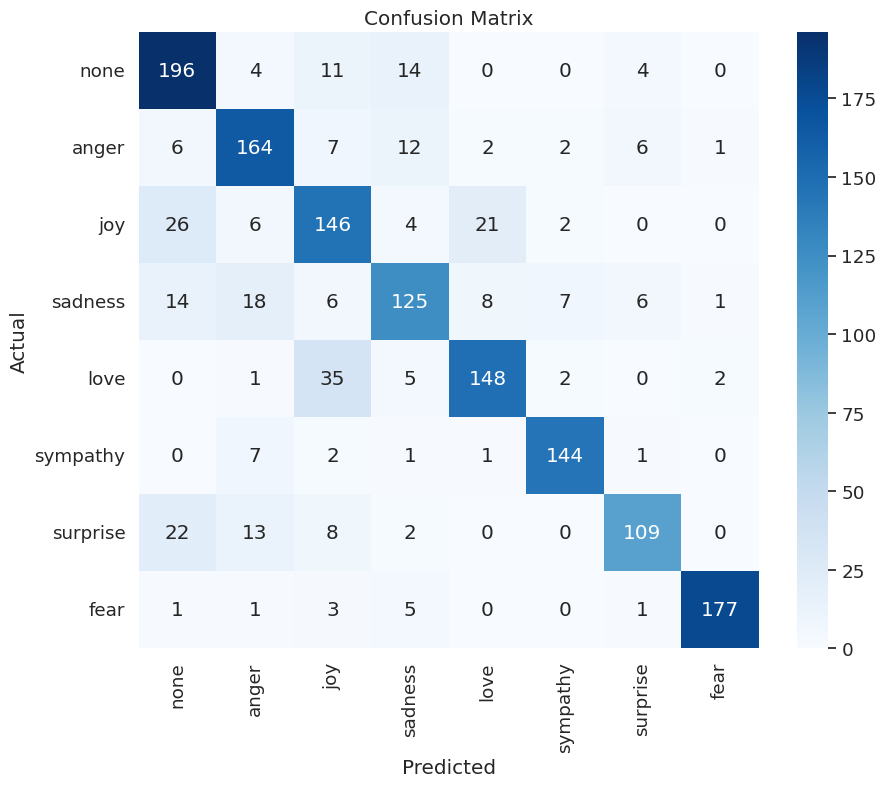

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_test['label'], test_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

####Train Data

In [27]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_train]
attention_masks = [i['attention_mask'] for i in X_train]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
train_data = TensorDataset(inputs, masks)

train_dataloader = DataLoader(train_data, batch_size=batch_size)

In [28]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

train_pred = []
for input, masks in train_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    train_pred.extend(predictions)

print(classification_report(X_train['label'], train_pred, target_names=classes))

              precision    recall  f1-score   support

        none       0.81      0.91      0.86      1074
       anger       0.84      0.91      0.88      1019
         joy       0.77      0.84      0.81       891
     sadness       0.87      0.75      0.80       885
        love       0.90      0.85      0.87       850
    sympathy       0.93      0.97      0.95       755
    surprise       0.87      0.73      0.79       729
        fear       0.98      0.94      0.96       842

    accuracy                           0.87      7045
   macro avg       0.87      0.86      0.87      7045
weighted avg       0.87      0.87      0.86      7045



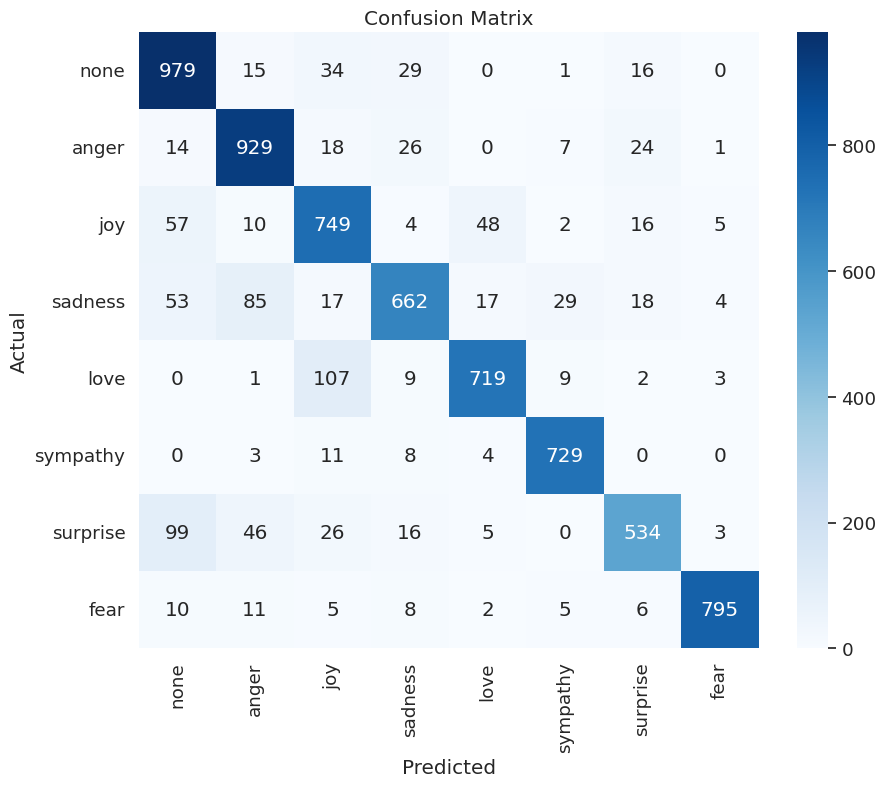

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_train['label'], train_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

####Dev Data

In [30]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_dev]
attention_masks = [i['attention_mask'] for i in X_dev]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
dev_data = TensorDataset(inputs, masks)

dev_dataloader = DataLoader(dev_data, batch_size=batch_size)

In [31]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

dev_pred = []
for input, masks in dev_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    dev_pred.extend(predictions)

print(classification_report(X_dev['label'], dev_pred, target_names=classes))

              precision    recall  f1-score   support

        none       0.74      0.86      0.79       229
       anger       0.77      0.82      0.79       200
         joy       0.67      0.71      0.69       205
     sadness       0.74      0.68      0.71       185
        love       0.82      0.77      0.79       193
    sympathy       0.92      0.92      0.92       156
    surprise       0.86      0.71      0.78       154
        fear       0.98      0.94      0.96       188

    accuracy                           0.80      1510
   macro avg       0.81      0.80      0.80      1510
weighted avg       0.80      0.80      0.80      1510



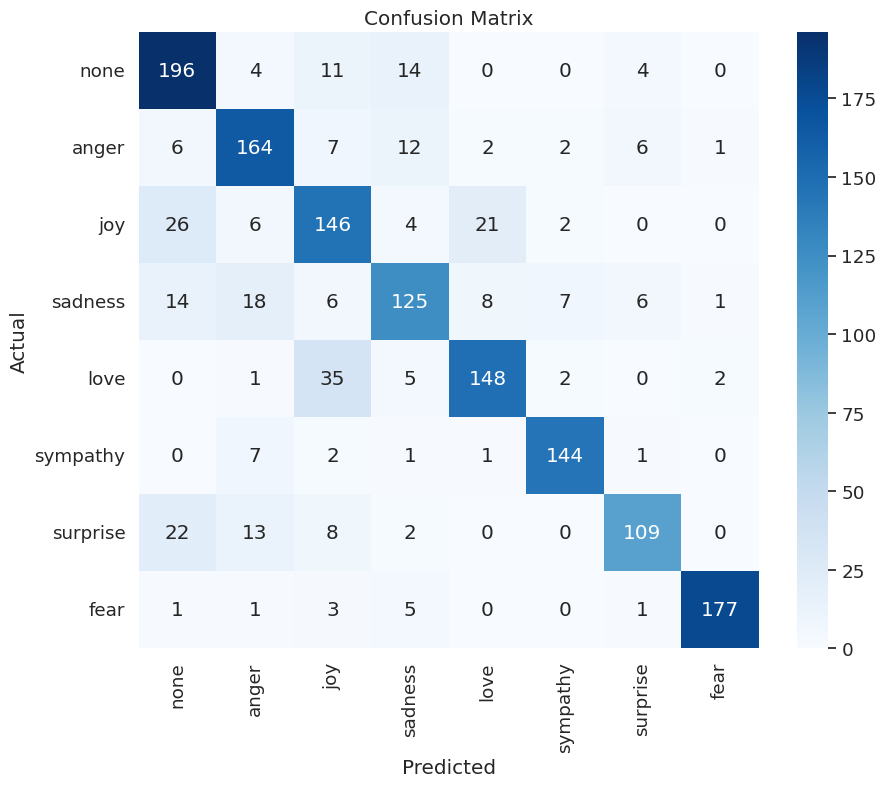

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_dev['label'], dev_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()